In [1]:
%matplotlib ipympl
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import os
import os.path as path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import subprocess
import ipywidgets as widgets
from ipywidgets import fixed, interact_manual, widgets
from IPython.display import display
import copy
from scipy.optimize import curve_fit
from scipy.stats import linregress
import pandas as pd
from matplotlib import rcParams
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Local module and scripts
from pyccapt.calibration.calibration import tools, share_variables
from pyccapt.calibration.calibration import widgets as wd
from pyccapt.calibration.data_tools import data_tools, data_loadcrop, dataset_path_qt
from pyccapt.calibration.leap_tools import ccapt_tools
from pyccapt.calibration.calibration import share_variables
from pyccapt.calibration.calibration import mc_plot

In [2]:
variables = share_variables.Variables()

In [3]:
# button = widgets.Button(description='load dataset')

# @button.on_click
# def open_file_on_click_r(b):
#     global dataset_path
#     folder_path = variables.last_directory
#     script = '..//..//data_tools//run_dataset_path_qt.py'
#     cmd = f"python {script} {folder_path}"
#     result = subprocess.run(cmd, capture_output=True, text=True, shell=True)
#     dataset_path = result.stdout.strip()
#     variables.last_directory = dataset_path

# button

In [4]:
# flightPathLength = 243 # 105.35 # mm 
# # The initial value for t_0
# t0 = 33 #68.48 # ns

# dataset name
# data_115_Jul-27-2022_17-44_Powersweep3

In [5]:
# ref_angle = 260
# ref_laser_intensity = 1.4e13
# pulse_energy = ref_laser_intensity * (10 ** ((angle - ref_angle) / (270 * 0.5)))
# # 1 μm^2 =1×10^−8 cm^2
# #Energy per pulse (J) = Power Density (W/cm^2) * Area (cm^2) * Pulse Duration (s)
# pulse_energy = pulse_energy * 6e-8 *  12e-15 * 1e12
# variables.data['pulse'] = pulse_energy

$$\textbf{You can specify the model of the TDC and dataset name down below}$$

In [6]:
tdc, pulse_mode, flightPathLength_d, t0_d, max_mc, det_diam = wd.dataset_instrument_specification_selection()
display(tdc, pulse_mode)

Dropdown(description='Data mode:', options=('pyccapt', 'leap_epos', 'leap_pos', 'leap_apt', 'ato_v6'), value='…

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

In [23]:
# dataset_path_171fs = 'T:/Monajem/manuscript/Atom_probe_tomography_using_ultra-short_laser_pulses/Data/data_115_Jul-27-2022_17-44_Powersweep3/data_processing/data_115_Jul-27-2022_17-44_Powersweep3.h5'
dataset_path_171fs = 'E:/Jonas/good_exp/data_226_Feb-18-2025_08-38_W_Poly/data_processing/data_226_Feb-18-2025_08-38_W_Poly.h5'
dataset_path_12fs =  'T:/Monajem/manuscript/Atom_probe_tomography_using_ultra-short_laser_pulses/Data/data_207_Feb-01-2024_13-08_Powersweep/data_processing/data_207_Feb-01-2024_13-08_Powersweep.h5'
# dataset_path_12ps = 'D:/pyccapt/tests/data/physics_experiment/R56_06712-v01/data_processing/R56_06712-v01.h5'
dataset_path_12ps = 'T:/Monajem/manuscript/Atom_probe_tomography_using_ultra-short_laser_pulses/Data/LEAP_R56_09319_W_RT_powersweep/R56_09319-v01.h5'
# dataset_path_171fs = 'C:/Users/mehrp/PycharmProjects/pyccapt/tests/data/physics_experiment/data_115_Jul-27-2022_17-44_Powersweep3/data_processing/data_115_Jul-27-2022_17-# # 44_Powersweep3.h5'
# dataset_path_12fs =  'C:/Users/mehrp/PycharmProjects/pyccapt/tests/data/physics_experiment/data_207_Feb-01-2024_13-08_Powersweep/data_processing/data_207_Feb-01-2024_13-# # 08_Powersweep.h5'
# dataset_path_12ps = 'C:/Users/mehrp/PycharmProjects/pyccapt/tests\data/physics_experiment/R56_06712-v01/data_processing/R56_06712-v01.h5'

In [24]:
# exctract needed data from Pandas data frame as an numpy array
# create an instance of the Variables opject
variables = share_variables.Variables()
variables.pulse_mode = pulse_mode

variables.result_data_path = 'D:/physics_experiment/results' 
variables.result_data_name = 'power_sweep'
variables.result_path ='D:/physics_experiment/results'

if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
    
# Create data farame out of hdf5 file dataset
data_171fs = data_tools.load_data(dataset_path_171fs, tdc.value, mode='processed')
data_12fs = data_tools.load_data(dataset_path_12fs, tdc.value, mode='processed')
data_12ps = data_tools.load_data(dataset_path_12ps, tdc.value, mode='processed')


In [25]:
data_12ps

,x (nm),y (nm),z (nm),mc (Da),mc_uc (Da),high_voltage (V),pulse,t (ns),t_c (ns),x_det (cm),y_det (cm),pulse_pi,ion_pp,start_counter
0,0.444552,-11.117000,1.442968,61.286091,0.0,7489.000000,50,2227.429688,0.0,0.066835,-0.740000,0,1,0
1,-7.723223,7.492853,1.348322,60.641232,0.0,7489.000000,50,2198.593262,0.0,-0.491908,0.503094,42,1,0
2,-0.149124,-18.853712,4.285962,60.655300,0.0,7489.000000,50,2206.651611,0.0,0.096243,-1.277698,163,1,0
3,12.722395,-6.839713,2.461384,61.304916,0.0,7489.000000,50,2253.595215,0.0,0.943714,-0.476475,82,1,0
4,4.955535,1.562915,0.310704,61.955269,0.0,7489.000000,50,2253.333252,0.0,0.342197,0.103813,281,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188729,-1.365878,2.545411,27.042448,91.050163,0.0,2729.659912,245,4485.849609,0.0,-0.235260,0.463165,90,1,0
1188730,-4.112113,0.634148,27.331936,101.037201,0.0,2729.659912,245,4684.967285,0.0,-0.721821,0.117122,65,1,0
1188731,-0.125170,2.560386,26.985825,101.017403,0.0,2729.659912,245,4742.244141,0.0,-0.010694,0.465827,11,1,0
1188732,-4.691450,-5.880054,28.670160,92.021805,0.0,2729.659912,245,4439.848633,0.0,-0.775289,-1.133957,225,1,0


In [26]:
# # Assuming 'df' is your DataFrame
# data_12ps_2 = data_12ps[300000:1188733].reset_index(drop=True)
# # cropped_data_171fs = data_171fs.iloc[0:].reset_index(drop=True)
# data_loadcrop.plot_crop_experiment_history(data_12ps_2, variables, max_tof=5000, data_crop=False, pulse_plot=True, pulse_mode='laser')

In [27]:
print('The data will be saved on the path:', variables.result_data_path)
print('=============================')
print('The dataset name after saving is:', variables.result_data_name)
print('=============================')
print('The figures will be saved on the path:', variables.result_path)
print('=============================')
print('Total number of Ions: data_171fs', len(data_171fs))
print('Total number of Ions: data_12fs', len(data_12fs))
print('Total number of Ions: data_12ps', len(data_12ps))


The data will be saved on the path: D:/physics_experiment/results
The dataset name after saving is: power_sweep
The figures will be saved on the path: D:/physics_experiment/results
Total number of Ions: data_171fs 399393
Total number of Ions: data_12fs 736753
Total number of Ions: data_12ps 1188734


In [13]:
# laser_power = np.zeros(len(data['high_voltage (V)'].to_numpy()))
# print(len(laser_power))
# laser_power[0:22100] = 50
# laser_power[22100:50000] = 60 #pJ
# laser_power[50000:100000] = 70
# laser_power[100000:150000] = 80
# laser_power[150000:200000] = 90
# laser_power[200000:250000] = 100
# laser_power[250000:300000] = 110
# laser_power[300000:350000] = 120
# laser_power[350000:400000] = 130
# laser_power[400000:450000] = 140
# laser_power[450000:500000] = 150
# laser_power[500000:550000] = 160


# data.insert(6, 'pulse (deg)', laser_power)
# del data['pulse']

In [14]:
# # Define step size and initial pulse value
# step_size = 30000
# initial_pulse = 50

# # Get the length of the DataFrame
# n_rows = len(variables.data)

# # Generate the pulse values directly for the entire column
# pulse_values = np.repeat(np.arange(initial_pulse, initial_pulse + 5 * (n_rows // step_size + 1), 5), step_size)

# # # Trim the pulse_values to match the length of the DataFrame if needed
# pulse_values = pulse_values[:n_rows]

# # # Assign the pulse_values directly to the "pulse" column
# variables.data['pulse'] = pulse_values

In [15]:
# # the difference that we have between laser intensity
# intensity = data['pulse'].to_numpy()
# new_intensity = np.unique(intensity)
# for i in range(len(new_intensity)):
#     if i+1 < len(new_intensity):
#         print(new_intensity[i+1] - new_intensity[i])

In [29]:
def find_step_changes(array):
    step_changes = []
    prev_value = array[0]
    
    for i in range(1, len(array)):
        if array[i] > prev_value:
            step_changes.append(i)
            prev_value = array[i]

    return step_changes

def calculate_step_means(array, step_changes):
    step_means = []

    for i in range(len(step_changes) - 1):
        start_index = step_changes[i]
        end_index = step_changes[i + 1]
        step_mean = sum(array[start_index:end_index]) / (end_index - start_index)
        step_means.append(step_mean)

    # Calculate mean for the last step
    last_step_mean = sum(array[step_changes[-1]:]) / (len(array) - step_changes[-1])
    step_means.append(last_step_mean)

    return step_means

def calculate_step_values(array, step_changes):
    step_values = []

    for i in range(len(step_changes) - 1):
        start_index = step_changes[i]
        end_index = step_changes[i + 1]
        values_in_step = array[start_index:end_index]
        step_values.append(values_in_step)

    # Values for the last step
    values_in_last_step = array[step_changes[-1]:]
    step_values.append(values_in_last_step)

    return step_values

def extract_step_values(array, step_changes):
    step_values = []

    for index in step_changes:
        step_values.append(array[index])

    return step_values

def ratio_calculator(mc, range_1, range_2, range_3, range_4, flag_oxides='none'):
    ratios_tmp_w2_r = []
    ratios_tmp_wo2_r = []
    w2 = 0
    for i, mc_step in enumerate(mc):
        
        W2_2pluse = mc_step[(mc_step > range_4[0]) & (mc_step < range_4[1])]
        W_3pluse = mc_step[(mc_step > range_3[0]) & (mc_step < range_3[1])]
        W_2pluse = mc_step[(mc_step > range_2[0]) & (mc_step < range_2[1])]
        W_1pluse = mc_step[(mc_step > range_1[0]) & (mc_step < range_1[1])]
        
        if flag_oxides == 'fs':
            #to add oxides of 12 fs in ratio
            W_2pluse_o_12fs_1 = mc_step[(mc_step > 98.5) & (mc_step < 101.5)]
            W_2pluse_o_12fs_2 = mc_step[(mc_step > 106.5) & (mc_step < 109.6)]
            W_2pluse_o_12fs_3 = mc_step[(mc_step > 197.5) & (mc_step < 202.6)]

            print(len(W_2pluse), len(W_3pluse) + len(W_1pluse) + len(W2_2pluse), len(W_2pluse) + len(W_3pluse) + len(W_1pluse) + len(W2_2pluse))
            ratios_tmp_w2_r.append(len(W_2pluse)/(len(W_3pluse) + len(W_1pluse) + len(W2_2pluse) + len(W_2pluse)))
            ratios_tmp_wo2_r.append(len(W_2pluse_o_12fs_1)/(len(W_2pluse_o_12fs_2) + len(W_2pluse_o_12fs_3) + len(W_2pluse_o_12fs_1)))
            w2 += len(W2_2pluse)


        elif flag_oxides == 'ps':
            #to add oxides of 12 fs in ratio
            W_2pluse_o_12fs_1 = mc_step[(mc_step > 98.5) & (mc_step < 101.5)]
            W_2pluse_o_12fs_2 = mc_step[(mc_step > 106.5) & (mc_step < 109.6)]
            W_2pluse_o_12fs_3 = mc_step[(mc_step > 197.5) & (mc_step < 202.6)]

            print(len(W_2pluse), len(W_3pluse) + len(W_1pluse) + len(W2_2pluse), len(W_2pluse) + len(W_3pluse) + len(W_1pluse) + len(W2_2pluse))
            ratios_tmp_w2_r.append(len(W_2pluse)/(len(W_3pluse) + len(W_1pluse) + len(W2_2pluse) + len(W_2pluse)))
            ratios_tmp_wo2_r.append(len(W_2pluse_o_12fs_1)/(len(W_2pluse_o_12fs_2) + len(W_2pluse_o_12fs_3) + len(W_2pluse_o_12fs_1)))
            w2 += len(W2_2pluse)

        elif flag_oxides == 'none':
            print(len(W_2pluse), len(W_3pluse) + len(W_1pluse) + len(W2_2pluse), len(W_2pluse) + len(W_3pluse) + len(W_1pluse) + len(W2_2pluse))
            ratios_tmp_w2_r.append(len(W_2pluse)/(len(W_3pluse) + len(W_1pluse) + len(W2_2pluse) + len(W_2pluse)))
            ratios_tmp_wo2_r.append(0)
            w2 += len(W2_2pluse)

        
    return ratios_tmp_w2_r, ratios_tmp_wo2_r, w2

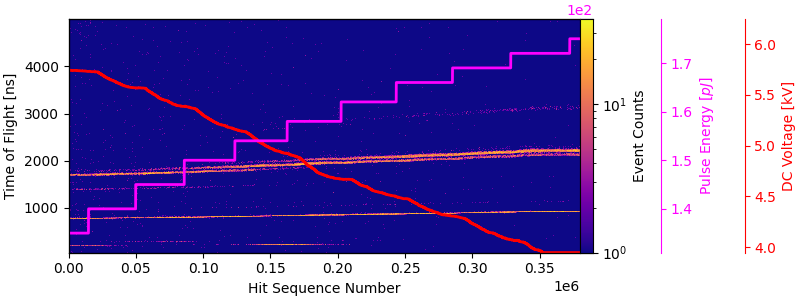

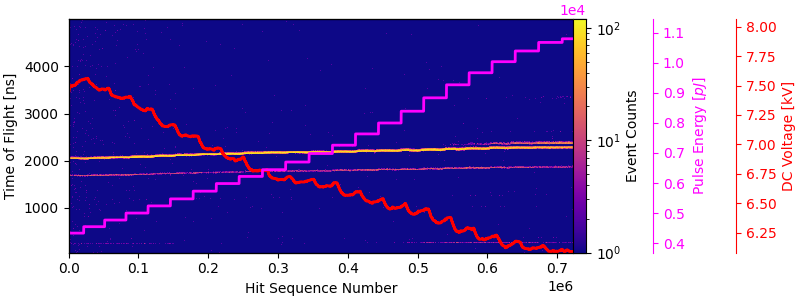

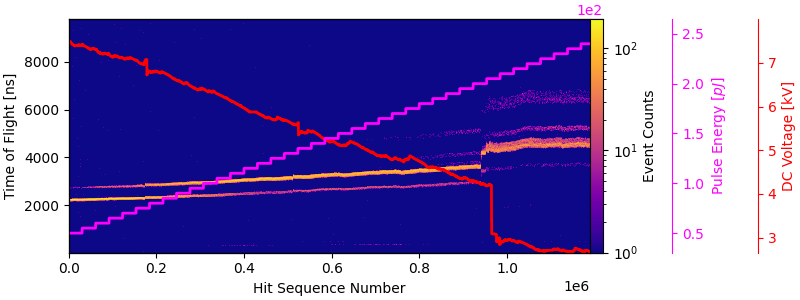

In [28]:
data_loadcrop.plot_crop_experiment_history(data_171fs, variables, max_tof=5000, data_crop=False, pulse_plot=True, pulse_mode='laser')
data_loadcrop.plot_crop_experiment_history(data_12fs, variables, max_tof=5000, data_crop=False, pulse_plot=True, pulse_mode='laser')
data_loadcrop.plot_crop_experiment_history(data_12ps, variables, max_tof=15000, data_crop=False, pulse_plot=True, pulse_mode='laser')

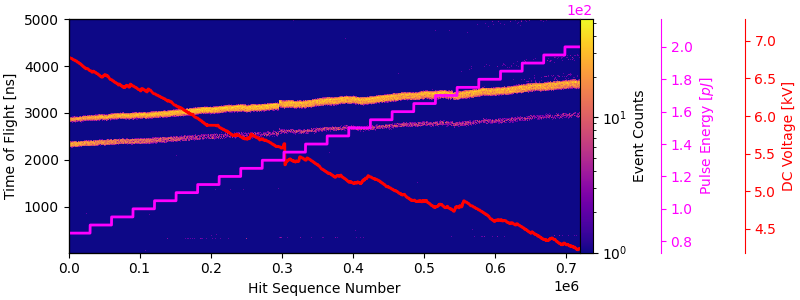

In [17]:
# Assuming 'df' is your DataFrame
# data_12ps = data_12ps[300000:1188733].reset_index(drop=True)
data_12ps = data_12ps[210000:940000].reset_index(drop=True)
# cropped_data_171fs = data_171fs.iloc[0:].reset_index(drop=True)
data_loadcrop.plot_crop_experiment_history(data_12ps, variables, max_tof=5000, data_crop=False, pulse_plot=True, pulse_mode='laser')

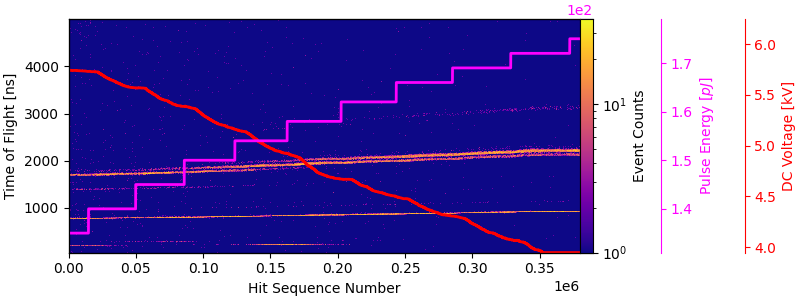

In [32]:
# Assuming 'df' is your DataFrame
# cropped_data_171fs = data_171fs.iloc[200000:].reset_index(drop=True)
cropped_data_171fs = data_171fs.iloc[0:].reset_index(drop=True)
data_loadcrop.plot_crop_experiment_history(cropped_data_171fs, variables, max_tof=5000, data_crop=False, pulse_plot=True, pulse_mode='laser')

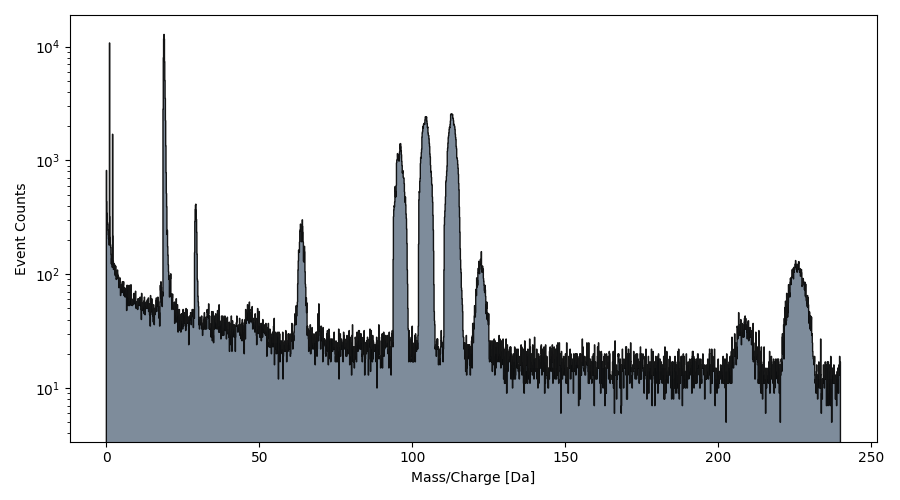

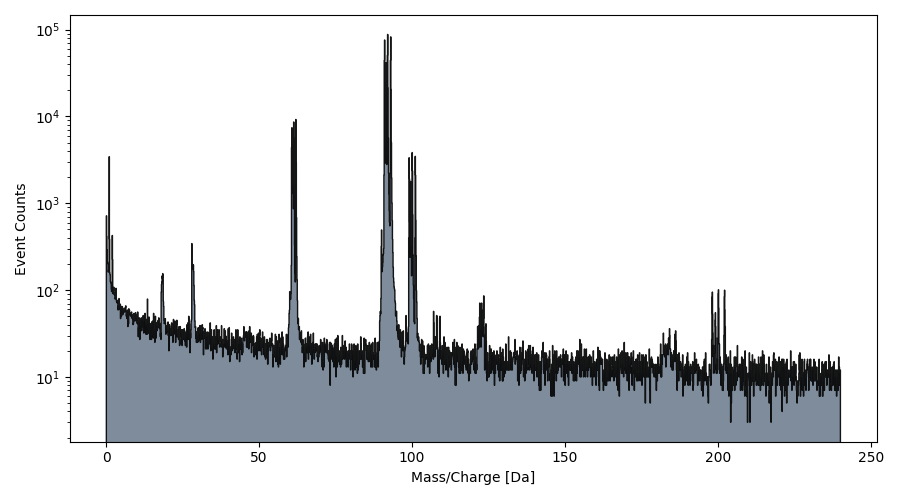

e:\pyccapt\pyccapt\calibration\calibration\mc_plot.py:99: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig, self.ax = plt.subplots(figsize=fig_size)


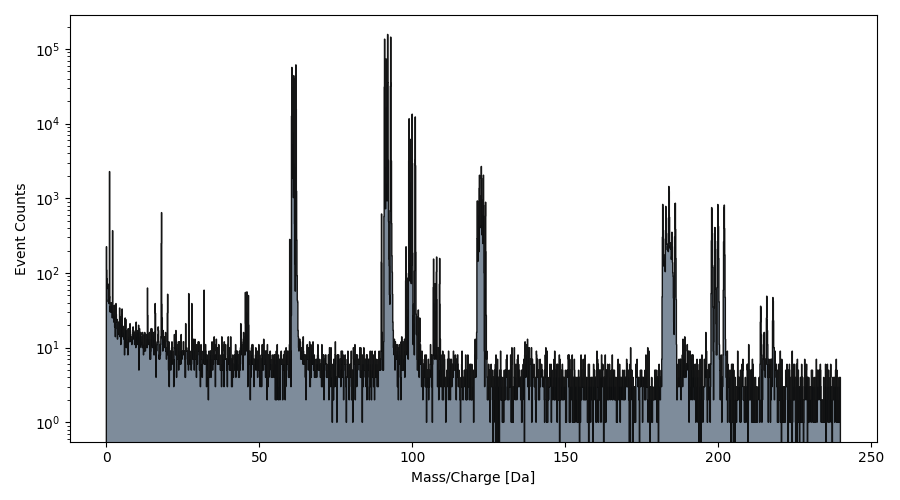

In [33]:
bin_size = 0.1
hist = data_171fs['mc (Da)'].to_numpy()
mc_hist = mc_plot.AptHistPlotter(hist[hist < 240], variables)
mc_hist.plot_histogram(bin_width=bin_size, label='mc', steps='stepfilled', log=True)
mc_hist.find_peaks_and_widths()
mc_hist.plot_hist_info_legend(loc='right')
hist = data_12fs['mc (Da)'].to_numpy()
mc_hist = mc_plot.AptHistPlotter(hist[hist < 240], variables)
mc_hist.plot_histogram(bin_width=bin_size, label='mc', steps='stepfilled', log=True)
mc_hist.find_peaks_and_widths()
mc_hist.plot_hist_info_legend(loc='right')
hist = data_12ps['mc (Da)'].to_numpy()
mc_hist = mc_plot.AptHistPlotter(hist[hist < 240], variables)
mc_hist.plot_histogram(bin_width=bin_size, label='mc', steps='stepfilled', log=True)
mc_hist.find_peaks_and_widths()
mc_hist.plot_hist_info_legend(loc='right')

10


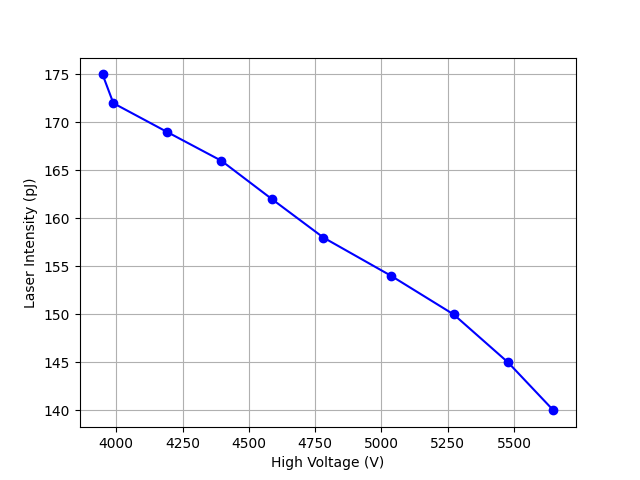

In [34]:
intensity = cropped_data_171fs['pulse'].to_numpy()
dc_voltage = cropped_data_171fs['high_voltage (V)'].to_numpy()
mc = cropped_data_171fs['mc (Da)'].to_numpy()

steps = find_step_changes(intensity)
print(len(steps))
intensity_values_171fs = extract_step_values(intensity, steps)
# intensity_values = np.log(intensity_values)
voltage_means_171fs = calculate_step_means(dc_voltage, steps)
mc_steps_171fs = calculate_step_values(mc, steps)

# Plotting
# Create a figure and axis
fig, ax = plt.subplots()
plt.plot(voltage_means_171fs, intensity_values_171fs, marker='o', linestyle='-', color='b')

plt.xlabel('High Voltage (V)')
plt.ylabel('Laser Intensity (pJ)')
# ax.set_yscale('log')  # Set y-axis to logarithmic scale
plt.grid(True)
plt.show()

22


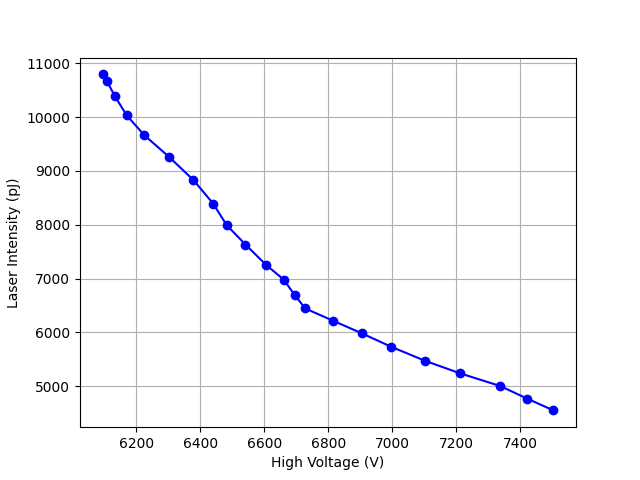

In [35]:
intensity = data_12fs['pulse'].to_numpy()
dc_voltage = data_12fs['high_voltage (V)'].to_numpy()
mc = data_12fs['mc (Da)'].to_numpy()

steps = find_step_changes(intensity)
print(len(steps))
intensity_values_12fs = extract_step_values(intensity, steps)
# intensity_values = np.log(intensity_values)
voltage_means_12fs = calculate_step_means(dc_voltage, steps)
mc_steps_12fs = calculate_step_values(mc, steps)

# Plotting
# Create a figure and axis
fig, ax = plt.subplots()
plt.plot(voltage_means_12fs, intensity_values_12fs, marker='o', linestyle='-', color='b')

plt.xlabel('High Voltage (V)')
plt.ylabel('Laser Intensity (pJ)')
# ax.set_yscale('log')  # Set y-axis to logarithmic scale
plt.grid(True)
plt.show()

39


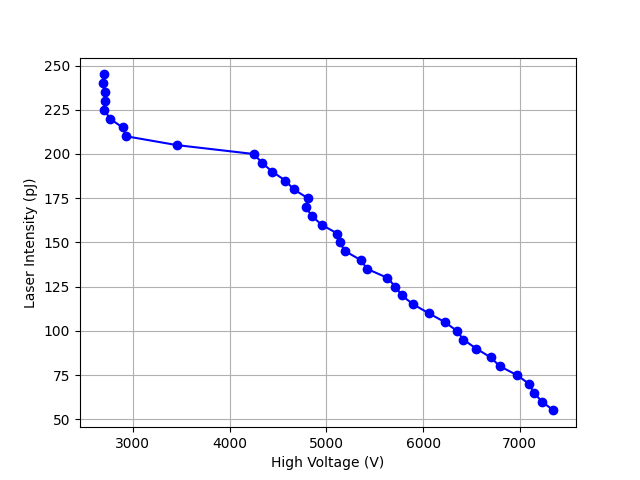

In [36]:
intensity = data_12ps['pulse'].to_numpy()
dc_voltage = data_12ps['high_voltage (V)'].to_numpy()
mc = data_12ps['mc (Da)'].to_numpy()

steps = find_step_changes(intensity)
print(len(steps))
intensity_values_12ps = extract_step_values(intensity, steps)
# intensity_values = np.log(intensity_values)
voltage_means_12ps = calculate_step_means(dc_voltage, steps)
mc_steps_12ps = calculate_step_values(mc, steps)

# Plotting
# Create a figure and axis
fig, ax = plt.subplots()
plt.plot(voltage_means_12ps, intensity_values_12ps, marker='o', linestyle='-', color='b')

plt.xlabel('High Voltage (V)')
plt.ylabel('Laser Intensity (pJ)')
# ax.set_yscale('log')  # Set y-axis to logarithmic scale
plt.grid(True)
plt.show()

In [37]:
ratios_w2_r = []  # List to store thee ratios
ratios_wo2_r = []  # List to store the ratios

In [38]:
# 171fs
range_1 = [180.7, 187.0]
range_2 = [90.2, 94.3]
range_3 = [60.1, 62.9]
range_4 = [120, 124.4]

    
ratios_w2_r_tmp, ratios_wo2_r_tmp, w2 = ratio_calculator(mc_steps_171fs, range_1, range_2, range_3, range_4, flag_oxides='none')
print(w2)
ratios_w2_r.append(ratios_w2_r_tmp)
ratios_wo2_r.append(ratios_wo2_r_tmp)

589 405 994
611 357 968
528 325 853
305 262 567
128 446 574
91 678 769
96 772 868
73 941 1014
64 1100 1164
18 408 426
3692


In [39]:
# 12fs

range_1 = [180.7, 187.0]
range_2 = [90.2, 94.3]
range_3 = [60.1, 62.9]
range_4 = [120, 124.4]


ratios_w2_r_tmp, ratios_wo2_r_tmp, w2 = ratio_calculator(mc_steps_12fs, range_1, range_2, range_3, range_4, flag_oxides='fs')
print(w2)
ratios_w2_r.append(ratios_w2_r_tmp)
ratios_wo2_r.append(ratios_wo2_r_tmp)

19230 2725 21955
21348 2596 23944
23425 2642 26067
25106 2144 27250
26449 1834 28283
27412 1694 29106
27156 1571 28727
28321 1568 29889
28177 1583 29760
28438 1612 30050
28223 1816 30039
27587 2041 29628
26903 2702 29605
26065 3121 29186
25619 3275 28894
25943 3303 29246
25259 3504 28763
25155 3456 28611
23887 3301 27188
22533 2982 25515
20791 2539 23330
18304 2345 20649
1270


In [40]:
# 12ps old dataset
# range_1 = [183.6, 184.2]
# range_2 = [91.7, 92.2]
# range_3 = [61.1, 61.4]
# 12ps new dataset
range_1 = [180.7, 187.0]
range_2 = [90.2, 94.3]
range_3 = [60.1, 62.9]
range_4 = [120, 124.4]

ratios_w2_r_tmp, ratios_wo2_r_tmp, w2 = ratio_calculator(mc_steps_12ps, range_1, range_2, range_3, range_4, flag_oxides='ps')
print(w2)
ratios_w2_r.append(ratios_w2_r_tmp)
ratios_wo2_r.append(ratios_wo2_r_tmp)


1011 27357 28368
2319 25949 28268
3562 24892 28454
4538 24045 28583
7253 21057 28310
11076 17409 28485
13268 15621 28889
16534 12326 28860
18963 9780 28743
20324 8619 28943
22492 6692 29184
24465 4675 29140
25678 3247 28925
26353 2814 29167
26485 2558 29043
26685 2630 29315
25901 3256 29157
25944 3393 29337
25825 3418 29243
25779 3339 29118
25918 3517 29435
25688 3670 29358
25709 3570 29279
25664 3508 29172
25838 3437 29275
25837 3465 29302
25701 3648 29349
25478 3700 29178
24766 4018 28784
24428 4203 28631
21389 3640 25029
15671 3019 18690
15832 3372 19204
14586 3299 17885
15259 3824 19083
17379 4863 22242
17496 4861 22357
18326 5300 23626
11414 3356 14770
21503


In [41]:
ratio_12_ps_r_w2 = np.array(ratios_w2_r[2])
ratio_12_fs_r_w2 = np.array(ratios_w2_r[1])
ratio_171_fs_r_w2 = np.array(ratios_w2_r[0])


ratio_12_ps_r_w2o = np.array(ratios_wo2_r[2])
ratio_12_fs_r_w2o = np.array(ratios_wo2_r[1])
ratio_171_fs_r_w2o = np.array(ratios_wo2_r[0])


pe_12_ps = np.array(intensity_values_12ps)
pe_12_fs = np.array(intensity_values_12fs)
pe_171_fs = np.array(intensity_values_171fs)


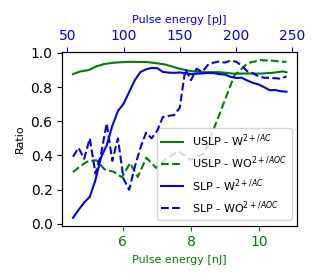

In [42]:
# Plotting

fig = plt.figure(figsize=(3.2,2.8))
ax1=fig.add_subplot(111, label="1")
# ax2=fig.add_subplot(111, label="2", frame_on=False)
# Plot data for ax1
ax1.plot(pe_12_fs / 1000, ratio_12_fs_r_w2, label=r'USLP - $\mathrm{W}^{2+/AC}$', color='green')
ax1.plot(pe_12_fs / 1000, ratio_12_fs_r_w2o, color='green', linestyle='--', label=r'USLP - $\mathrm{WO}^{2+/AOC}$')


ax1.set_xlabel('Pulse energy [nJ]', color='green', fontsize=8)
ax1.set_ylabel('Ratio', fontsize=8)
ax1.tick_params(axis='x', colors='green')  # Set Y-axis tick labels color to red
# ax1.set_yscale('log')


ax2 = ax1.twiny()  # Create a secondary x-axis
ax2.plot(pe_12_ps, ratio_12_ps_r_w2, color='blue', label=r'SLP - $\mathrm{W}^{2+/AC}$')  # Invisible plot to create the secondary x-axis
ax2.plot(pe_12_ps, ratio_12_ps_r_w2o, color='blue', linestyle='--', label=r'SLP - $\mathrm{WO}^{2+/AOC}$')  # Invisible plot to create the secondary x-axis
ax2.set_xlabel('Pulse energy [pJ]', color='blue', fontsize=8)
ax2.tick_params(axis='x', colors='blue')  # Set Y-axis tick labels color to red
ax2.tick_params(axis='y', colors='blue')  # Set Y-axis tick labels color to red

# Combine legends from ax1 and ax2
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', fontsize=8)

plt.tight_layout()
plt.savefig(variables.result_path + "/temperature.png", format="png", dpi=600)
plt.savefig(variables.result_path + "/temperature.svg", format="svg", dpi=600)

# print('fs min max last', np.min(ratio_12_fs_r_w2_3_oxide), np.max(ratio_12_fs_r_w2_3_oxide), ratio_12_ps_r_w2_3_oxide[-1])
# print('fs min max last', np.min(ratio_12_ps_r_w2_3_oxide), np.max(ratio_12_ps_r_w2_3_oxide), ratio_12_ps_r_w2_3_oxide[-1])
plt.show()

NameError: name 'ratio_12_fs_r_w1_2' is not defined

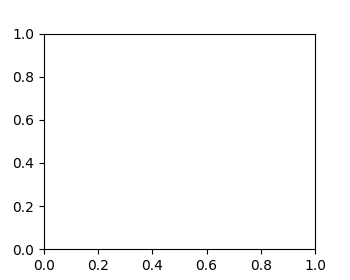

In [43]:
# Plotting

fig = plt.figure(figsize=(3.5,2.8))
ax1=fig.add_subplot(111, label="1")
# ax2=fig.add_subplot(111, label="2", frame_on=False)
ax1.plot(pe_12_fs/1000, ratio_12_fs_r_w1_2, marker='o', label='12fs-pulses', color='green')

ax1.set_xlabel('Pulse energy [nJ]', color='green', fontsize=8)
ax1.set_ylabel('W$^{+}$ / W$^{2+}$', fontsize=8)
ax1.tick_params(axis='x', colors='green')  # Set Y-axis tick labels color to red
# ax1.set_yscale('log')


ax2 = ax1.twiny()  # Create a secondary x-axis
ax2.plot(pe_12_ps, ratio_12_ps_r_w1_2, marker='s', color='blue', label='12ps-pulses')  # Invisible plot to create the secondary x-axis
ax2.set_xlabel('Pulse energy [pJ]', color='blue', fontsize=8)
ax2.tick_params(axis='x', colors='blue')  # Set Y-axis tick labels color to red
ax2.tick_params(axis='y', colors='blue')  # Set Y-axis tick labels color to red

# Combine legends from ax1 and ax2
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8)

plt.tight_layout()
# plt.savefig(variables.result_path + "temperature.png", format="png", dpi=600)
# plt.savefig(variables.result_path + "temperature.svg", format="svg", dpi=600)
plt.show()

NameError: name 'ratio_12_fs_r_w2_3' is not defined

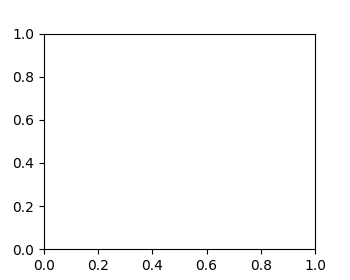

In [44]:
# Plotting

fig = plt.figure(figsize=(3.5,2.8))
ax1=fig.add_subplot(111, label="1")
# ax2=fig.add_subplot(111, label="2", frame_on=False)
ax1.plot(pe_12_fs/1000, ratio_12_fs_r_w2_3, marker='o', label='12fs-pulses', color='green')

ax1.set_ylabel('W$^{2+}$ / W$^{3+}$')
ax1.set_xlabel('Pulse energy [nJ]', color='green', fontsize=8)
ax1.set_ylabel('W$^{2+}$ / W$^{3+}$', fontsize=8)
ax1.tick_params(axis='x', colors='green')  # Set Y-axis tick labels color to red
# ax1.set_yscale('log')

ax2 = ax1.twiny()  # Create a secondary x-axis
ax2.plot(pe_171_fs / 1e3, ratio_171_fs_r_w2_3, marker='s', color='red', label='171fs-pulses')  # Invisible plot to create the secondary x-axis
ax2.set_xlabel('Pulse energy [nJ]', color='red', fontsize=8)
ax2.tick_params(axis='x', colors='red')  # Set Y-axis tick labels color to red
ax2.tick_params(axis='y', colors='red')  # Set Y-axis tick labels color to red


# Combine legends from ax1 and ax2
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=8)

plt.tight_layout()
# plt.savefig(variables.result_path + "temperature.png", format="png", dpi=600)
# plt.savefig(variables.result_path + "temperature.svg", format="svg", dpi=600)
plt.show()

C:\Users\APTUser\AppData\Local\Temp\ipykernel_25300\1015615261.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(3.5,2.8))


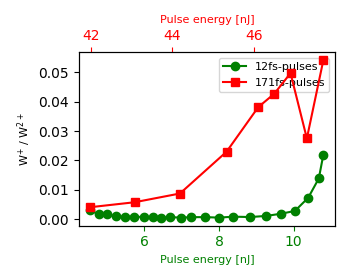

In [47]:
# Plotting

fig = plt.figure(figsize=(3.5,2.8))
ax1=fig.add_subplot(111, label="1")
# ax2=fig.add_subplot(111, label="2", frame_on=False)
ax1.plot(pe_12_fs/1000, ratio_12_fs_r_w1_2, marker='o', label='12fs-pulses', color='green')


ax1.set_xlabel('Pulse energy [nJ]', color='green', fontsize=8)
ax1.set_ylabel('W$^{+}$ / W$^{2+}$', fontsize=8)
ax1.tick_params(axis='x', colors='green')  # Set Y-axis tick labels color to red
# ax1.set_yscale('log')

ax2 = ax1.twiny()  # Create a secondary x-axis
ax2.plot(pe_171_fs / 1e3, ratio_171_fs_r_w1_2, marker='s', color='red', label='171fs-pulses')  # Invisible plot to create the secondary x-axis
ax2.set_xlabel('Pulse energy [nJ]', color='red', fontsize=8)
ax2.tick_params(axis='x', colors='red')  # Set Y-axis tick labels color to red
ax2.tick_params(axis='y', colors='red')  # Set Y-axis tick labels color to red


# Combine legends from ax1 and ax2
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=8)

plt.tight_layout()
# plt.savefig(variables.result_path + "temperature.png", format="png", dpi=600)
# plt.savefig(variables.result_path + "temperature.svg", format="svg", dpi=600)
plt.show()

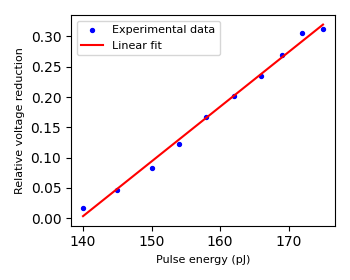

In [45]:
# Convert lists to NumPy arrays
intensity_values_s = np.array(intensity_values_171fs)
voltage_means_s = np.array(voltage_means_171fs)
dc_voltage = data_171fs['high_voltage (V)'].to_numpy()

intensity_values_s = (intensity_values_s - np.min(intensity_values_s)) / (np.max(intensity_values_s) - np.min(intensity_values_s))
# intensity_values_s = (intensity_values_s) / (np.max(intensity_values_s))
# intensity_values_s = (intensity_values_s) / 40000
voltage_means_s = (np.max(dc_voltage) - voltage_means_s) / np.max(dc_voltage)


# voltage_means_s = np.array(voltage_reduction)
# Split the data into two ranges (0 to 19 and 20 to the end)
intensity_values_1 = intensity_values_s[:]
voltage_means_1 = voltage_means_s[:]

log_intensity_values_1 = intensity_values_1

# Define linear and quadratic functions for log-transformed data
def linear_func(x, a, b):
    return a * x + b

def square_root_func(x, a, b):
    return a * np.sqrt(x) + b

# Fit a linear function for both ranges
params_linear_log_1, _ = curve_fit(linear_func, log_intensity_values_1, voltage_means_1)
# params_linear_log_2, _ = curve_fit(linear_func_log, voltage_means_2, log_intensity_values_2)

# Fit quadratic function for both ranges
params_quadratic_log_1, _ = curve_fit(square_root_func, log_intensity_values_1, voltage_means_1)
# params_quadratic_log_2, _ = curve_fit(quadratic_func_log, voltage_means_2, log_intensity_values_2)


fig = plt.figure(figsize=(3.5,2.8))
ax=fig.add_subplot(111, label="1")
# ax2=fig.add_subplot(111, label="2", frame_on=False)

# Plotting for the first range (0 to 19)
ax.scatter(np.array(intensity_values_171fs), voltage_means_1, label='Experimental data', color='b', s=8)
# x_fit = np.linspace(min(log_intensity_values_1), max(log_intensity_values_1), 100)
ax.plot(np.array(intensity_values_171fs), linear_func(log_intensity_values_1, *params_linear_log_1), label='Linear fit', color='r')
# ax.plot(np.array(intensity_values_171fs), square_root_func(log_intensity_values_1, *params_quadratic_log_1), label='Square-root fit', color='g')


# plt.yscale('log')  # Set y-axis to logarithmic scale
ax.set_ylabel('Relative voltage reduction', fontsize=8)
ax.set_xlabel('Pulse energy (pJ)', fontsize=8)
ax.legend(fontsize=8)



# scatter_plot = ax2.scatter(intensity_values, voltage_means, color='b')
# ax2.xaxis.tick_top()
# ax2.yaxis.tick_right()
# ax2.xaxis.set_label_position('top') 
# ax2.yaxis.set_label_position('right') 
# ax2.set_ylabel('Voltage [V]')
# ax2.set_xlabel('Pulse energy [pJ]')
# scatter_plot.remove()
# plt.grid(True)
plt.tight_layout()
# rcParams['font.sans-serif'] = ['Arial']
# rcParams['svg.fonttype'] = 'none'
# plt.savefig(variables.result_path + "fs_PE_vs_voltage.png", format="png", dpi=600)
# plt.savefig(variables.result_path + "fs_PE_vs_voltage.svg", format="svg", dpi=600)
# plt.savefig(variables.result_path + "LEAP_PE_vs_voltage.png", format="png", dpi=600)
# plt.savefig(variables.result_path + "LEAP_PE_vs_voltage.svg", format="svg", dpi=600)

plt.show()


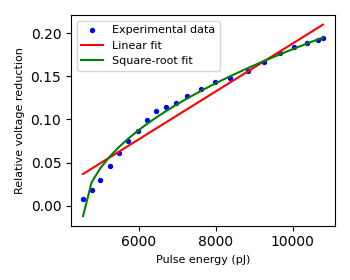

In [46]:
# Convert lists to NumPy arrays
intensity_values_s = np.array(intensity_values_12fs)
voltage_means_s = np.array(voltage_means_12fs)
dc_voltage = data_12fs['high_voltage (V)'].to_numpy()

intensity_values_s = (intensity_values_s - np.min(intensity_values_s)) / (np.max(intensity_values_s) - np.min(intensity_values_s))
# intensity_values_s = (intensity_values_s) / (np.max(intensity_values_s))
# intensity_values_s = (intensity_values_s) / 40000
voltage_means_s = (np.max(dc_voltage) - voltage_means_s) / np.max(dc_voltage)


# voltage_means_s = np.array(voltage_reduction)
# Split the data into two ranges (0 to 19 and 20 to the end)
intensity_values_1 = intensity_values_s[:]
voltage_means_1 = voltage_means_s[:]

log_intensity_values_1 = intensity_values_1

# Define linear and quadratic functions for log-transformed data
def linear_func(x, a, b):
    return a * x + b

def square_root_func(x, a, b):
    return a * np.sqrt(x) + b

# Fit a linear function for both ranges
params_linear_log_1, _ = curve_fit(linear_func, log_intensity_values_1, voltage_means_1)
# params_linear_log_2, _ = curve_fit(linear_func_log, voltage_means_2, log_intensity_values_2)

# Fit quadratic function for both ranges
params_quadratic_log_1, _ = curve_fit(square_root_func, log_intensity_values_1, voltage_means_1)
# params_quadratic_log_2, _ = curve_fit(quadratic_func_log, voltage_means_2, log_intensity_values_2)


fig = plt.figure(figsize=(3.5,2.8))
ax=fig.add_subplot(111, label="1")
# ax2=fig.add_subplot(111, label="2", frame_on=False)

# Plotting for the first range (0 to 19)
ax.scatter(np.array(intensity_values_12fs), voltage_means_1, label='Experimental data', color='b', s=8)
# x_fit = np.linspace(min(log_intensity_values_1), max(log_intensity_values_1), 100)
ax.plot(np.array(intensity_values_12fs), linear_func(log_intensity_values_1, *params_linear_log_1), label='Linear fit', color='r')
ax.plot(np.array(intensity_values_12fs), square_root_func(log_intensity_values_1, *params_quadratic_log_1), label='Square-root fit', color='g')


# plt.yscale('log')  # Set y-axis to logarithmic scale
ax.set_ylabel('Relative voltage reduction', fontsize=8)
ax.set_xlabel('Pulse energy (pJ)', fontsize=8)
ax.legend(fontsize=8)



# scatter_plot = ax2.scatter(intensity_values, voltage_means, color='b')
# ax2.xaxis.tick_top()
# ax2.yaxis.tick_right()
# ax2.xaxis.set_label_position('top') 
# ax2.yaxis.set_label_position('right') 
# ax2.set_ylabel('Voltage [V]')
# ax2.set_xlabel('Pulse energy [pJ]')
# scatter_plot.remove()
# plt.grid(True)
plt.tight_layout()
# rcParams['font.sans-serif'] = ['Arial']
# rcParams['svg.fonttype'] = 'none'
# plt.savefig(variables.result_path + "fs_PE_vs_voltage.png", format="png", dpi=600)
# plt.savefig(variables.result_path + "fs_PE_vs_voltage.svg", format="svg", dpi=600)
# plt.savefig(variables.result_path + "LEAP_PE_vs_voltage.png", format="png", dpi=600)
# plt.savefig(variables.result_path + "LEAP_PE_vs_voltage.svg", format="svg", dpi=600)

plt.show()


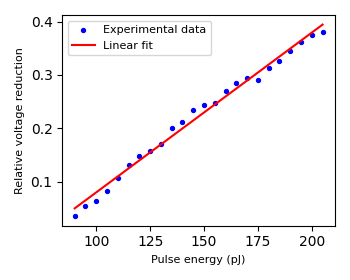

In [50]:
# Convert lists to NumPy arrays
intensity_values_s = np.array(intensity_values_12ps)
voltage_means_s = np.array(voltage_means_12ps)
dc_voltage = data_12ps['high_voltage (V)'].to_numpy()

intensity_values_s = (intensity_values_s - np.min(intensity_values_s)) / (np.max(intensity_values_s) - np.min(intensity_values_s))
# intensity_values_s = (intensity_values_s) / (np.max(intensity_values_s))
# intensity_values_s = (intensity_values_s) / 40000
voltage_means_s = (np.max(dc_voltage) - voltage_means_s) / np.max(dc_voltage)


# voltage_means_s = np.array(voltage_reduction)
# Split the data into two ranges (0 to 19 and 20 to the end)
intensity_values_1 = intensity_values_s[:]
voltage_means_1 = voltage_means_s[:]

log_intensity_values_1 = intensity_values_1

# Define linear and quadratic functions for log-transformed data
def linear_func(x, a, b):
    return a * x + b

def square_root_func(x, a, b):
    return a * np.sqrt(x) + b

# Fit a linear function for both ranges
params_linear_log_1, _ = curve_fit(linear_func, log_intensity_values_1, voltage_means_1)
# params_linear_log_2, _ = curve_fit(linear_func_log, voltage_means_2, log_intensity_values_2)

# Fit quadratic function for both ranges
params_quadratic_log_1, _ = curve_fit(square_root_func, log_intensity_values_1, voltage_means_1)
# params_quadratic_log_2, _ = curve_fit(quadratic_func_log, voltage_means_2, log_intensity_values_2)


fig = plt.figure(figsize=(3.5,2.8))
ax=fig.add_subplot(111, label="1")
# ax2=fig.add_subplot(111, label="2", frame_on=False)

# Plotting for the first range (0 to 19)
ax.scatter(np.array(intensity_values_12ps), voltage_means_1, label='Experimental data', color='b', s=8)
# x_fit = np.linspace(min(log_intensity_values_1), max(log_intensity_values_1), 100)
ax.plot(np.array(intensity_values_12ps), linear_func(log_intensity_values_1, *params_linear_log_1), label='Linear fit', color='r')
# ax.plot(np.array(voltage_means_12ps), square_root_func(log_intensity_values_1, *params_quadratic_log_1), label='Square-root fit', color='g')


# plt.yscale('log')  # Set y-axis to logarithmic scale
ax.set_ylabel('Relative voltage reduction', fontsize=8)
ax.set_xlabel('Pulse energy (pJ)', fontsize=8)
ax.legend(fontsize=8)



# scatter_plot = ax2.scatter(intensity_values, voltage_means, color='b')
# ax2.xaxis.tick_top()
# ax2.yaxis.tick_right()
# ax2.xaxis.set_label_position('top') 
# ax2.yaxis.set_label_position('right') 
# ax2.set_ylabel('Voltage [V]')
# ax2.set_xlabel('Pulse energy [pJ]')
# scatter_plot.remove()
# plt.grid(True)
plt.tight_layout()
# rcParams['font.sans-serif'] = ['Arial']
# rcParams['svg.fonttype'] = 'none'
# plt.savefig(variables.result_path + "fs_PE_vs_voltage.png", format="png", dpi=600)
# plt.savefig(variables.result_path + "fs_PE_vs_voltage.svg", format="svg", dpi=600)
plt.savefig(variables.result_path + "/LEAP_PE_vs_voltage.png", format="png", dpi=600)
plt.savefig(variables.result_path + "/LEAP_PE_vs_voltage.svg", format="svg", dpi=600)

plt.show()


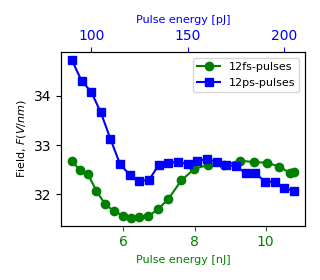

In [54]:
# static filed calculation
# Based on the https://academic.oup.com/mam/article/30/3/466/7688643
ratio_12_ps_r_w3_2 = 1 / ratio_12_ps_r_w2_3
ratio_12_fs_r_w3_2 = 1 / ratio_12_fs_r_w2_3

a = 40.21
b = 0.1849
filed_12ps = a * (1- (b / (ratio_12_ps_r_w3_2**0.3 + b + 0.256)))
filed_12fs = a * (1- (b / (ratio_12_fs_r_w3_2**0.3 + b + 0.256)))

# Creating the plot
fig, ax1 = plt.subplots(figsize=(3.2,2.8))

# Plotting for pe_12_fs (bottom x-axis)
ax1.plot(pe_12_fs / 1000, filed_12fs, marker='o', label='12fs-pulses', color='green')
ax1.set_xlabel('Pulse energy [nJ]', color='green', fontsize=8)
ax1.set_ylabel('Field', fontsize=8)
ax1.tick_params(axis='x', colors='green')

# Secondary x-axis for pe_12_ps (top x-axis)
ax2 = ax1.twiny()
ax2.plot(pe_12_ps, filed_12ps, marker='s', color='blue', label='12ps-pulses')
ax2.set_xlabel('Pulse energy [pJ]', color='blue', fontsize=8)
ax2.tick_params(axis='x', colors='blue')

# Shared y-axis (field) - already done via ax1
ax1.set_ylabel('Field, $F (V/nm)$', fontsize=8)

# Combine legends from ax1 and ax2
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2,  loc='upper right', fontsize=8)

# Adjust layout
plt.tight_layout()
plt.savefig(variables.result_path + "/filed_LEAP_PE_ps_voltage.png", format="png", dpi=600)
plt.savefig(variables.result_path + "/filed_LEAP_PE_ps_voltage.svg", format="svg", dpi=600)
plt.show()



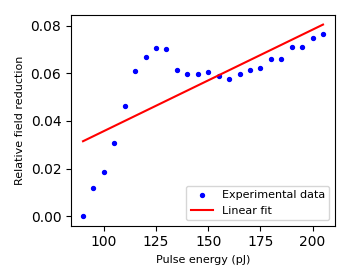

In [52]:
# Normalize intensity values (as done in the previous code)
intensity_values_s = np.array(intensity_values_12ps)
intensity_values_s = (intensity_values_s - np.min(intensity_values_s)) / (np.max(intensity_values_s) - np.min(intensity_values_s))

filed_12ps_s = (filed_12ps[0] - filed_12ps) / filed_12ps[0]

# Define linear and square root functions for fitting
def linear_func(x, a, b):
    return a * x + b

def square_root_func(x, a, b):
    return a * np.sqrt(x) + b

# Fit a linear function for the log-transformed data
params_linear_log_1, _ = curve_fit(linear_func, intensity_values_s, filed_12ps_s)

# Fit a quadratic function for the log-transformed data
params_quadratic_log_1, _ = curve_fit(square_root_func, intensity_values_s, filed_12ps_s)

# Create a plot for field reduction
fig = plt.figure(figsize=(3.5, 2.8))
ax = fig.add_subplot(111, label="1")

# Scatter plot for the experimental data (relative field reduction)
ax.scatter(np.array(intensity_values_12ps), filed_12ps_s, label='Experimental data', color='b', s=8)

# Plot the linear fit
ax.plot(np.array(intensity_values_12ps), linear_func(intensity_values_s, *params_linear_log_1), label='Linear fit', color='r')

# You can also plot the square-root fit if needed
# ax.plot(np.array(intensity_values_12ps), square_root_func(intensity_values_s, *params_quadratic_log_1), label='Square-root fit', color='g')

# Labeling and legends
ax.set_ylabel('Relative field reduction', fontsize=8)
ax.set_xlabel('Pulse energy (pJ)', fontsize=8)
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


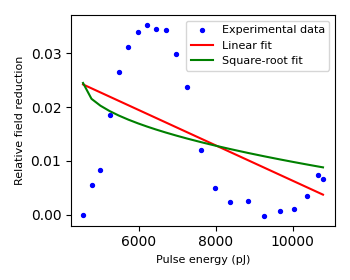

In [53]:
# Normalize intensity values (as done in the previous code)
intensity_values_s = np.array(intensity_values_12fs)
intensity_values_s = (intensity_values_s - np.min(intensity_values_s)) / (np.max(intensity_values_s) - np.min(intensity_values_s))

filed_12fs_s = (filed_12fs[0] - filed_12fs) / filed_12fs[0]

# Define linear and square root functions for fitting
def linear_func(x, a, b):
    return a * x + b

def square_root_func(x, a, b):
    return a * np.sqrt(x) + b

# Fit a linear function for the log-transformed data
params_linear_log_1, _ = curve_fit(linear_func, intensity_values_s, filed_12fs_s)

# Fit a quadratic function for the log-transformed data
params_quadratic_log_1, _ = curve_fit(square_root_func, intensity_values_s, filed_12fs_s)

# Create a plot for field reduction
fig = plt.figure(figsize=(3.5, 2.8))
ax = fig.add_subplot(111, label="1")

# Scatter plot for the experimental data (relative field reduction)
ax.scatter(np.array(intensity_values_12fs), filed_12fs_s, label='Experimental data', color='b', s=8)

# Plot the linear fit
ax.plot(np.array(intensity_values_12fs), linear_func(intensity_values_s, *params_linear_log_1), label='Linear fit', color='r')

# You can also plot the square-root fit if needed
ax.plot(np.array(intensity_values_12fs), square_root_func(intensity_values_s, *params_quadratic_log_1), label='Square-root fit', color='g')

# Labeling and legends
ax.set_ylabel('Relative field reduction', fontsize=8)
ax.set_xlabel('Pulse energy (pJ)', fontsize=8)
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()